In [1]:
import pandas as pd
import time
from tqdm import tqdm

In [2]:
%%time
maindata = pd.read_csv('data_train_NLP_shopee.csv',sep='^',low_memory=False)
df_en = maindata['en']
df_tcn = maindata['tcn']

Wall time: 149 ms


In [3]:
print("English sentences:", len(df_en))
print("Tr. Chinese sentences:", len(df_tcn))

English sentences: 80505
Tr. Chinese sentences: 80505


In [4]:
print(df_en.head())
print(df_tcn.head())

print("English sentences (new):", len(df_en))
print("Tr. Chinese sentences (new):", len(df_tcn))

0    (bts fansite goods) rap monster/rm photocard s...
1    (znb) 10pcs/box rainbow solid color washi stic...
2    (samsung case s3/s4/s5/s6/s6 edge/s6 edge plus...
3           (sealed) exid me & you album (with poster)
4    (case 42）oppo f3/f5/f7/f9/plus/a77/a73/a79/f11...
Name: en, dtype: object
0         （bts迷信商品）說唱世界的Rap Monster / RM Photocard Set
1      （znb）10pcs /盒彩虹純色紙膠帶紙印刷diy overtranscendence.ph
2    （三星情況s3 / s4 / s5 / s6 / s6 edge / s6 edge plu...
3                   （封印）exid me＆you album（with poster）
4    （案例42）oppo f3 / f5 / f7 / f9 / plus / a77 / a7...
Name: tcn, dtype: object
English sentences (new): 80505
Tr. Chinese sentences (new): 80505


In [5]:
df_en = df_en.drop(df_en.index[0:152]).reset_index().drop('index', axis=1)
df_tcn = df_tcn.drop(df_tcn.index[0:152]).reset_index().drop('index', axis=1)

print(df_en.head())
print(df_tcn.head())

print("English sentences (new):", len(df_en))
print("Tr. Chinese sentences (new):", len(df_tcn))

                                                  en
0                    ✅iphone 6 16gb factory unlocked
1  iphone 6 plus/6splus rainbow 360 full protecti...
2  iphone 6 plus mobile phone case jelly transpar...
3                        iphone 6 (factory unlocked)
4                    iphone 6s 64gb factory unlocked
                                                 tcn
0                                  iPhone 6 16GB工廠解鎖
1  iPhone 6 Plus / 6Splus Rainbow 360全面保護TPU / PC...
2                          iPhone 6 Plus手機殼果凍透明mypro
3                                     iPhone 6（工廠解鎖）
4                                iPhone 6s 64GB出廠已解鎖
English sentences (new): 80353
Tr. Chinese sentences (new): 80353


# TRAIN - TEST PROCESS

In [6]:
import pandas as pd
import string, re
import numpy as np
import matplotlib.pyplot as plt
from keras import optimizers
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Embedding, RepeatVector
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


       eng_wordcount  tcn_wordcount
0                  5              3
1                 14              9
2                  9              3
3                  4              2
4                  5              3
...              ...            ...
80348              8              3
80349              6              2
80350              5              1
80351              7              7
80352              6              1

[80353 rows x 2 columns]


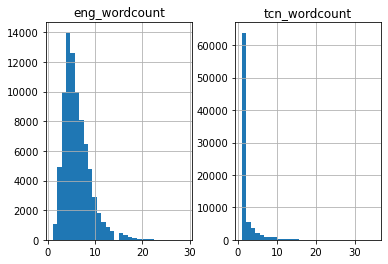

In [7]:
eng_word_count = []
tcn_word_count = []

for i in df_en['en']:
    eng_word_count.append(len(str(i).split()))

for j in df_tcn['tcn']:
    tcn_word_count.append(len(str(j).split()))

length_df = pd.DataFrame({'eng_wordcount':eng_word_count, 
                          'tcn_wordcount':tcn_word_count})
print(length_df)
length_df.hist(bins = 30) 
plt.show()

In [8]:
def tokenization(lines): 
    tokenizer = Tokenizer() 
    tokenizer.fit_on_texts(str(lines))
    return tokenizer

eng_tokenizer = tokenization(df_en['en']) 
eng_vocab_size = len(eng_tokenizer.word_index) + 1 
eng_length = 30

tcn_tokenizer = tokenization(df_tcn['tcn']) 
tcn_vocab_size = len(tcn_tokenizer.word_index) + 1 
tcn_length = 30

In [13]:
from sklearn.model_selection import train_test_split 

def encode_sequences(tokenizer, length, lines):
    seq = tokenizer.texts_to_sequences(str(lines))          
    seq = pad_sequences(seq,
                     maxlen = length, 
                     padding = 'post')           
    return seq

train, test = train_test_split(maindata,
                               test_size = 0.2,
                               random_state = 1)

ENG_train = train['en']
ENG_test  = test['en']
TCN_train = train['tcn']
TCN_test  = test['tcn']
    
# prepare training data 
trainX = encode_sequences(tcn_tokenizer, tcn_length, TCN_train) 
trainY = encode_sequences(eng_tokenizer, eng_length, ENG_train) 

# prepare validation data 
testX = encode_sequences(tcn_tokenizer, tcn_length, TCN_test) 
testY = encode_sequences(eng_tokenizer, eng_length, ENG_test)

def build_model(in_vocab, out_vocab, in_timesteps, out_timesteps, n):   
      model = Sequential() 
      model.add(Embedding(in_vocab, 
                          n, 
                          input_length = in_timesteps,   
                          mask_zero = True)
               ) 
      model.add(LSTM(n)) 
      model.add(RepeatVector(out_timesteps)) 
      model.add(LSTM(n, return_sequences=True))  
      model.add(Dense(out_vocab, activation='softmax')) 
      return model

from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
filepath="D:\\Personal Coding\\NLP - Subs Translation - ZHTW to ENG\\weight\\weights-improvement-{epoch:02d}-{accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath,
                             save_best_only=True,
                             save_weights_only=True,
                             monitor='accuracy',
                             mode='max',
                             verbose=1)
rlrp = ReduceLROnPlateau(factor=0.9, patience=3, min_lr=0.001, verbose=1)

model = build_model(tcn_vocab_size, 
                    eng_vocab_size, 
                    tcn_length, 
                    eng_length, 
                    200)

rms = optimizers.Adam(lr=0.005)
model.compile(optimizer=rms, 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

training_session = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
                             epochs=5,
                             batch_size=1,
                             validation_split=0.3,
                             verbose=1
                            )

Epoch 1/5
373/373 [==============================] - 11s 30ms/step - loss: 0.1278 - accuracy: 0.9814 - val_loss: 0.0969 - val_accuracy: 0.9768
Epoch 2/5
373/373 [==============================] - 11s 30ms/step - loss: 0.0845 - accuracy: 0.9814 - val_loss: 0.3779 - val_accuracy: 0.9333
Epoch 3/5
373/373 [==============================] - 13s 34ms/step - loss: 0.7896 - accuracy: 0.9422 - val_loss: 2.0246 - val_accuracy: 0.8720
Epoch 4/5
373/373 [==============================] - 12s 33ms/step - loss: 0.9093 - accuracy: 0.9350 - val_loss: 1.9958 - val_accuracy: 0.8640
Epoch 5/5
373/373 [==============================] - 12s 31ms/step - loss: 0.8617 - accuracy: 0.9349 - val_loss: 1.9544 - val_accuracy: 0.8640


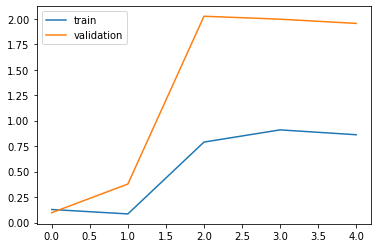

In [14]:
plt.plot(training_session.history['loss']) 
plt.plot(training_session.history['val_loss']) 
plt.legend(['train','validation']) 
plt.show()

In [ ]:
# save model in json file and its weight
model_json = model.to_json()
with open("model_TCN_ENG.json","w") as json_file:
    json_file.write(model_json)
    
model.save_weights("model_TCN_ENG.h5")

print("Model and weight saved in local computer")

In [17]:
preds = model.predict_classes(testX.reshape((testX.shape[0], testX.shape[1])))

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [18]:
def get_word(n, tokenizer):  
    for word, index in tokenizer.word_index.items():                       
        if index == n: 
            return word 
        return None

In [19]:
preds_text = [] 
for i in preds:        
    temp = []        
    for j in range(len(i)):             
        t = get_word(i[j], eng_tokenizer)             
        if j > 0:                 
            if (t == get_word(i[j-1],eng_tokenizer)) or (t== None):                       
                 temp.append('')                 
            else:                      
                 temp.append(t)             
        else:                    
            if(t == None):                                   
                 temp.append('')                    
            else:                           
                 temp.append(t)        
    preds_text.append(' '.join(temp))

In [20]:
len(TCN_test[0:445])

445

In [21]:
len(preds_text)

545

In [22]:
preds_text

['                             ',
 '                             ',
 '                             ',
 '                             ',
 '                             ',
 '                             ',
 '                             ',
 '                             ',
 '                             ',
 '                             ',
 '                             ',
 '                             ',
 '                             ',
 '                             ',
 '                             ',
 '                             ',
 '                             ',
 '                             ',
 '                             ',
 '                             ',
 '                             ',
 '                             ',
 '                             ',
 '                             ',
 '                             ',
 '                             ',
 '                             ',
 '                             ',
 '                             ',
 '            

In [61]:
pred_df = pd.DataFrame({'Sources Sentences'              : TCN_test[0:445],
                        'Predicted Translated Sentences' : preds_text,
                        'Actual Translated Sentences'    : ENG_test[0:445]})
pred_df.head()

,Sources Sentences,Predicted Translated Sentences,Actual Translated Sentences
20166,sagmit skewer,,sagmit skewer
56760,電視機頂蓋,,tv cover for led tv on hand
50696,新娘背包,,bride backpack
66584,可以龐蒂盒減肥咖啡/飲食,,can po indi box slimming coffee / diatary
66343,maam jonna personalized mug,,maam jonna personalized mug
